In [1]:
%load_ext autoreload
%autoreload 2

from lrp import *
from lrp.data import Data
from lrp import read_mnist
import os
from lrp.evaluate_rule import HeatmapEval
from lrp import utils
import os

/home/niels/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# train a good cnn and a good fcn
mnist = read_mnist.read_data_sets("{}/datasets/mnist".format(os.environ["TF_PROJECTS"]), one_hot=True)
data = Data(X=mnist.train.images, y=mnist.train.labels,
                X_val=mnist.validation.images, y_val=mnist.validation.labels,
                X_test=mnist.test.images, y_test=mnist.test.labels)
fcn = Network([Format(), FirstLinear(784), ReLU(), NextLinear(10)], data.X, data.y_)
cnn = Network([Format(), FirstConvolution([5, 5, 1, 32]), ReLU(), Pooling(),
               NextConvolution([5, 5, 32, 64]), ReLU(), Pooling(),
               NextLinear(1024), ReLU(),
               NextLinear(10)],
               data.X, data.y_)


    
    
# show some heatmaps

# show the graph how pertubations destroy the value

# show some pertubated images

Extracting /home/niels/Dokumente/Informatik/bachelor/tensorflow/datasets/mnist/train-images-idx3-ubyte.gz
Extracting /home/niels/Dokumente/Informatik/bachelor/tensorflow/datasets/mnist/train-labels-idx1-ubyte.gz
Extracting /home/niels/Dokumente/Informatik/bachelor/tensorflow/datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting /home/niels/Dokumente/Informatik/bachelor/tensorflow/datasets/mnist/t10k-labels-idx1-ubyte.gz
Network layer mappings: (?, 784)
-> (?, 784)
-> (?, 784)
-> (?, 10)
Network layer mappings: (?, 784)
-> (?, 24, 24, 32)
-> (?, 24, 24, 32)
-> (?, 12, 12, 32)
-> (?, 8, 8, 64)
-> (?, 8, 8, 64)
-> (?, 4, 4, 64)
-> (?, 1024)
-> (?, 1024)
-> (?, 10)
INFO:tensorflow:Restoring parameters from trained_models/example_fcn/model.ckpt
INFO:tensorflow:Restoring parameters from trained_models/example_cnn/model.ckpt


INFO:tensorflow:Restoring parameters from trained_models/example_fcn/model.ckpt
INFO:tensorflow:Restoring parameters from trained_models/example_cnn/model.ckpt
Evaluate simple on fcn
Visualized heatmaps
Evaluate simple-ref on fcn
Visualized heatmaps
Evaluate deeptaylor on fcn
Visualized heatmaps
Evaluate deeptaylor-ref on fcn
Visualized heatmaps
Evaluate zbab on fcn
Visualized heatmaps
Evaluate zbab-ref on fcn
Visualized heatmaps
Evaluate simple on cnn
Visualized heatmaps
Evaluate simple-ref on cnn
Visualized heatmaps
Evaluate deeptaylor on cnn
Visualized heatmaps
Evaluate deeptaylor-ref on cnn
Visualized heatmaps
Evaluate zbab on cnn
Visualized heatmaps
Evaluate zbab-ref on cnn
Visualized heatmaps
--------- COMPARE -----------------
eval <lrp.train.Network object at 0x7f0b1d02e6d8> simple
Eval  fcn
Scores
order (784, 100)
eval <lrp.train.Network object at 0x7f0b1d02e6d8> simple-ref
Eval  fcn
Scores
order (784, 100)
eval <lrp.train.Network object at 0x7f0b1d02e6d8> deeptaylor
Eval  fcn

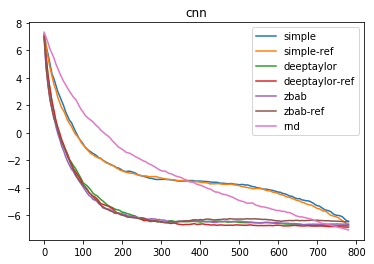

In [10]:
nns = [fcn, cnn]

rules = ["simple",
         ("simple", {"reference": data.X_val}),
         "deeptaylor",
         ("deeptaylor", {"reference": data.X_val}),
         "zbab",
         ("zbab", {"reference": data.X_val})]

evaluator = HeatmapEval(nns, ["fcn", "cnn"],
                        rules, ["simple", "simple-ref", "deeptaylor", "deeptaylor-ref", "zbab", "zbab-ref", ],
                        data)

with tf.Session() as sess:
    
    fcn.set_session(sess)
    cnn.set_session(sess)

    sess.run(tf.global_variables_initializer())

    try:
        fcn.load_params("trained_models/example_fcn")
    except:
        print("Train new fcn")
        fcn.fit(data, lambda i, val_acc: max([0]+val_acc)<=0.98)
        fcn.save_params("trained_models/example_fcn")

    try:
        cnn.load_params("trained_models/example_cnn")
    except:
        print("Train new cnn")
        cnn.fit(data, lambda i, val_acc: max([0]+val_acc)<=0.98)
        cnn.save_params("trained_models/example_cnn")
    
    os.makedirs("evaluate/heatmaps", exist_ok=True)

    for nn_name, nn in zip(["fcn", "cnn"], nns):

        for rule_name, H in zip(evaluator.rule_names, evaluator.heatmaps[nn]):
            print("Evaluate", rule_name, "on", nn_name)
            heatmaps, prediction = sess.run([H, nn.y], feed_dict={data.X: data.X_test[:16], data.y_: data.y_test[:16]})
            utils.visualize(heatmaps, utils.heatmap_original, "evaluate/heatmaps/{}-{}.png".format(
                nn_name, rule_name))
            plt.show()
            print("Visualized heatmaps")

    print("--------- COMPARE -----------------")
    evaluator.compare()
    evaluator.plot_effect(".")
    plt.show()